In [58]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### Let's load the Nashville zipcode data and look at the first few rows
- geopandas reads files with the `read_file()` method
- The zipcode data was downloaded from https://data.nashville.gov/General-Government/Zip-Codes/u7r5-bpku


In [59]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [60]:
type(zipcodes)

geopandas.geodataframe.GeoDataFrame

#### Note that _if_ the crs contains init it needs to be [updated](https://geopandas.org/projections.html) as shown in the cell below

In [61]:
# zipcodes.geometry.to_crs('EPSG:4326')
# print(zipcodes.crs)

#### Now let's look at the difference between calling the first geometry variable.....


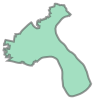

In [62]:
zipcodes.loc[0, 'geometry']

#### ...and printing it


print(zipcodes.loc[0, 'geometry'])

#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


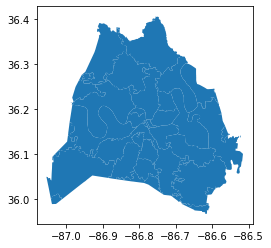

In [63]:
zipcodes.plot();

#### Add information and styling 
- set the `column =` to a column in the GeoDataFrame to color by
- change the [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) 
- pass in keywords to tweak the legend created by `matplotib`

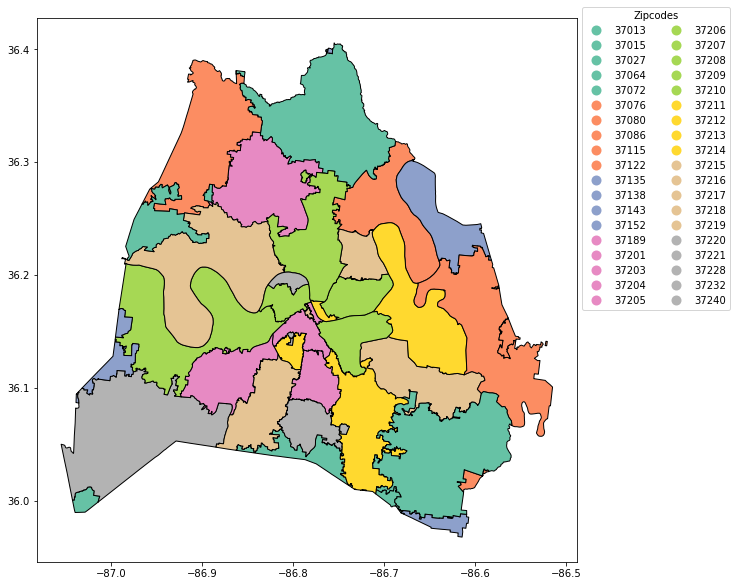

In [64]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

zipcodes.plot(column = 'zip', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

#### Next you will read in the bus stop data
- downloaded from https://data.nashville.gov/Transportation/Regional-Transportation-Authority-Bus-Stops/p886-fnbd
- cleaned:
    - rename columns 
    - drop unwanted columns 
    - parse `lat` and `lng` columns from `location`
- print the shape 
- take a look at the first 3 rows

In [65]:
bus_stops = pd.read_csv('../data/busstops_cleaned.csv')
print(bus_stops.shape)
bus_stops.head(3)

(2524, 5)


,stop,route,location,lat,lng
0,GREEN LN & WHITES CREEK PIKE WB,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722
1,_ 9TH AVE S & EDGEHILL AVE SB,8TH AVENUE SOUTH,"(36.142642, -86.780897)",36.142642,-86.780897
2,DONELSON/DELL STATION OUTBOUND,MURFREESBORO PIKE,"(36.105615, -86.672004)",36.105615,-86.672004


In [66]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2524 entries, 0 to 2523
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   stop      2524 non-null   object 
 1   route     2524 non-null   object 
 2   location  2524 non-null   object 
 3   lat       2524 non-null   float64
 4   lng       2524 non-null   float64
dtypes: float64(2), object(3)
memory usage: 98.7+ KB


#### In order to spatially join the bus stops with the zipcodes, you will need to create a GeoDataFrame of bus stops
- First create a geometry column that is a `Point` datatype

In [67]:
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((x.lng, 
                                                         x.lat)), 
                                        axis=1)
bus_stops.head(3)

,stop,route,location,lat,lng,geometry
0,GREEN LN & WHITES CREEK PIKE WB,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722,POINT (-86.816722 36.236249)
1,_ 9TH AVE S & EDGEHILL AVE SB,8TH AVENUE SOUTH,"(36.142642, -86.780897)",36.142642,-86.780897,POINT (-86.780897 36.142642)
2,DONELSON/DELL STATION OUTBOUND,MURFREESBORO PIKE,"(36.105615, -86.672004)",36.105615,-86.672004,POINT (-86.672004 36.105615)


In [68]:
bus_stops = pd.read_csv('../data/busstops_cleaned.csv')

#### Now that the bus stops data has a geometry field, you can use it to build a GeoDataFrame 
- you want the CRS for the bus stops to match the CRS in the zipcodes GeoDataFrame 


In [69]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### The `GeoDataFrame()` constructor needs 3 parameters:
 - a DataFrame
 - a coordinate reference system
 - a geometry

In [70]:
bus_geo = gpd.GeoDataFrame(bus_stops, 
                           crs = zipcodes.crs, 
                           geometry = bus_stops['geometry'])

KeyError: 'geometry'

In [ ]:
type(bus_geo)

#### Now you are ready to combine bus stops and zipcodes with a spatial join
- first a little clean up for the zipcodes
    - just keep the zip, po_name, and geometry columns
- then construct the join 
    - keep in mind that you want to find the bus stops within a zip code polygon
    - the geometry for the new (combined) GeoDataFrame comes from the left GeoDataFrame


In [ ]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

In [ ]:
stops_by_zip = gpd.sjoin(bus_geo, zipcodes, op = 'within')

In [ ]:
stops_by_zip.head()

#### Now that the data is joined spatially you can count the bus stops by zip code  and see how many stops are within each polygon 
- using the `value_counts()` method


In [ ]:
stops_by_zip['zip'].value_counts()

#### Let's take a closer look at the 272 bus stops in the 37207 zip code
- filter the stops_by_zip data to just get bus stops in 37207
- filter the zip code geodataframe to just the polygon (row) for 37207


In [ ]:
stops_in_37207 = stops_by_zip.loc[stops_by_zip['zip'] == '37207']
stops_in_37207.shape

In [ ]:
polygon37207 = zipcodes.loc[zipcodes['zip'] == '37207']
polygon37207.shape

#### Now plot these two together
- first plot the polygons for 37207 and make them light green
- next plot the points for the bus stops and color them by route

In [ ]:
#fig, ax = matplotlib.subplots()
ax = polygon37207.plot(figsize = (8, 10), color = 'lightgreen')
stops_in_37207.plot( ax = ax, column = 'route');
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### folium maps require a center point for the street map. 
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon
- Since there are two polygons which should we use?

In [ ]:
polygon37207.geometry.centroid

In [ ]:
#find the center of the larger (more southern) polygon and look at it
center = polygon37207.geometry.centroid[42]
print(center)

#### Folium requires a location point as an array 
- with *latitude* first
- but shapely Points have *longitude* first 

In [ ]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

#### To create a folium map just call the folium `Map()` constructor
- `location` is the only argument required by the constructor
    - Set `area_center` as the `location` of the folium map. 
- `zoom_start` is an optional argument 
    - A setting of 12 should get us nice and close

In [ ]:
#create our map of Nashville Zip Code 37207 and show it
map_37207 = folium.Map(location =  area_center, zoom_start = 12)
map_37207

#### Next, let's add our 37207 polygon and bus stop markers.

#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. 
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of bus stops in 37207. 
- This idea will be helpful for creating our markers!

In [ ]:
i = 0
for row_index, row_values in stops_in_37207.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

#### Create map_37207 again with additional features:
- add the zipcode area outline (polygon_37207)
- iterate through the stops_in_37207 to
    - create location from each lat and lng
    - create a popup from the stop column
    - create a custom icon if you want with [font-awesome](https://fontawesome.com/v4.7.0/icons/)
    - build a marker from each location and popup and (optionally) your custom icon 
    - add the marker to  `map_37207`
- display `map_37207`

In [ ]:
#draw our zip code area: 37207
map_37207 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37207).add_to(map_37207)

#iterate through stops_in_37207 to create locations and markers 
#for each bus stop
#remember for Folium locations, lat is listed first!!

for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_37207)
map_37207.save('../maps/map37207.html')

#display our map
map_37207

#### If you have a lot of markers, you might want to use marker clusters
- Folium has `MarkerCluster()` and `FastMarkerCluster()`
- Construct a `MarkerCluster()` 
    - construct a `MarkerCluster()` and `.add_to()` the map
    - when you loop through the data and create markers add those to the marker cluster
- Construct a `FastMarkerCluster()` by passing a list of locations

#### You can save your map as an html file and it will retain the interactive qualities

In [ ]:
folium.Map?

In [ ]:
cluster_map_37207 = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_37207)

folium.GeoJson(polygon37207).add_to(cluster_map_37207)

# inside the loop add each marker to the cluster
for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_37207.save('../maps/cluster37207.html')

cluster_map_37207  

In [ ]:
#draw our zip code area: 37207
map_37207 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37207).add_to(map_37207)

#create a list of locations and pass them to FastMarkerCluster()
locations = stops_in_37207[['lat', 'lng']].values.tolist()
map_37207.add_child(
    FastMarkerCluster(locations)
)



#display our map
map_37207